In [1]:
import os
import sys

def add_to_sys_path(relative_path):
    abs_path = os.path.abspath(os.path.join(os.getcwd(), relative_path))
    if abs_path not in sys.path:
        sys.path.append(abs_path)

add_to_sys_path(os.path.join('..', '..', '..', 'Utils'))
add_to_sys_path(os.path.join('..', '..', '..', 'Model'))

In [2]:
import pandas as pd
import numpy as np
import random
import shap

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns

from TabNet import base_model as base_model_call
from model_data_processing import Data_Handler, Model_Metrics_Visualizer
from output_shuffling_attack import *

/home/jn/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
data = pd.read_csv('../../../Dataset/Kaggle-data.csv')
data.head()

/tmp/ipykernel_1024380/825226827.py:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('../../../Dataset/Kaggle-data.csv')


,ID,md5,Machine,SizeOfOptionalHeader,Characteristics,MajorLinkerVersion,MinorLinkerVersion,SizeOfCode,SizeOfInitializedData,SizeOfUninitializedData,...,ResourcesMeanEntropy,ResourcesMinEntropy,ResourcesMaxEntropy,ResourcesMeanSize,ResourcesMinSize,ResourcesMaxSize,LoadConfigurationSize,VersionInformationSize,legitimate,Unnamed: 57
0,1,b69acb3bb133974e48229627663f96d4,332,224,8450,8.0,0,16896,8192,0,...,3.492126,3.492126,3.492126,864.0,864.0,864,72,0,1,NaN
1,2,1cbee4b3725629bd0aa6ac2ff500925f,332,224,258,9.0,0,84480,25600,0,...,3.486827,3.486827,3.486827,892.0,892.0,892,72,0,1,NaN
2,3,b7027cf0cd31c820928950cbfe7e91ef,332,224,8450,8.0,0,4608,3584,0,...,3.517270,3.517270,3.517270,952.0,952.0,952,72,0,1,NaN
3,4,156a0bb069f94d1e7c2508318805f2a4,332,224,8450,10.0,0,108544,15872,0,...,3.270559,3.034188,3.506931,1032.0,972.0,1092,72,0,1,NaN
4,5,c72bf851fed5542abba904b1f3944cd5,332,224,8226,48.0,0,513024,2048,0,...,3.420977,3.420977,3.420977,954.0,954.0,954,0,0,1,NaN


In [4]:
data['legitimate'].value_counts()

legitimate
0    140849
1     75503
Name: count, dtype: int64

In [5]:
binary_columns = []
for col in data.columns:
    if len(set(data[col]))<10:
        binary_columns.append(col)

print("Binary columns:", binary_columns)

Binary columns: ['MajorSubsystemVersion', 'Subsystem', 'legitimate']


In [6]:
print(data[data['legitimate']==0]['Subsystem'].value_counts())
print(data[data['legitimate']==1]['Subsystem'].value_counts())

Subsystem
2    135280
3      5409
1       139
0        21
Name: count, dtype: int64
Subsystem
3     41732
2     31286
1      2370
16       58
9        57
Name: count, dtype: int64


In [7]:
# print(data[data['Class']==0]['magic_number'].value_counts())
# print(data[data['Class']==1]['magic_number'].value_counts())

In [8]:
data = data.drop(data.select_dtypes(include='object').columns, axis=1)
# print(data[data['Class']==0]['magic_number'].value_counts())
# print(data[data['Class']==1]['magic_number'].value_counts())
data.head()

,ID,SizeOfOptionalHeader,Characteristics,MajorLinkerVersion,MinorLinkerVersion,SizeOfCode,SizeOfInitializedData,SizeOfUninitializedData,AddressOfEntryPoint,BaseOfCode,...,ResourcesMeanEntropy,ResourcesMinEntropy,ResourcesMaxEntropy,ResourcesMeanSize,ResourcesMinSize,ResourcesMaxSize,LoadConfigurationSize,VersionInformationSize,legitimate,Unnamed: 57
0,1,224,8450,8.0,0,16896,8192,0,16947,4096,...,3.492126,3.492126,3.492126,864.0,864.0,864,72,0,1,NaN
1,2,224,258,9.0,0,84480,25600,0,10973,4096,...,3.486827,3.486827,3.486827,892.0,892.0,892,72,0,1,NaN
2,3,224,8450,8.0,0,4608,3584,0,6452,4096,...,3.517270,3.517270,3.517270,952.0,952.0,952,72,0,1,NaN
3,4,224,8450,10.0,0,108544,15872,0,105021,4096,...,3.270559,3.034188,3.506931,1032.0,972.0,1092,72,0,1,NaN
4,5,224,8226,48.0,0,513024,2048,0,520922,8192,...,3.420977,3.420977,3.420977,954.0,954.0,954,0,0,1,NaN


In [9]:
data = data.drop(columns=['ID', 'Unnamed: 57'])
data.head()

,SizeOfOptionalHeader,Characteristics,MajorLinkerVersion,MinorLinkerVersion,SizeOfCode,SizeOfInitializedData,SizeOfUninitializedData,AddressOfEntryPoint,BaseOfCode,BaseOfData,...,ResourcesNb,ResourcesMeanEntropy,ResourcesMinEntropy,ResourcesMaxEntropy,ResourcesMeanSize,ResourcesMinSize,ResourcesMaxSize,LoadConfigurationSize,VersionInformationSize,legitimate
0,224,8450,8.0,0,16896,8192,0,16947,4096,24576,...,1,3.492126,3.492126,3.492126,864.0,864.0,864,72,0,1
1,224,258,9.0,0,84480,25600,0,10973,4096,90112,...,1,3.486827,3.486827,3.486827,892.0,892.0,892,72,0,1
2,224,8450,8.0,0,4608,3584,0,6452,4096,12288,...,1,3.517270,3.517270,3.517270,952.0,952.0,952,72,0,1
3,224,8450,10.0,0,108544,15872,0,105021,4096,114688,...,2,3.270559,3.034188,3.506931,1032.0,972.0,1092,72,0,1
4,224,8226,48.0,0,513024,2048,0,520922,8192,524288,...,1,3.420977,3.420977,3.420977,954.0,954.0,954,0,0,1


In [10]:
protected_feature='Subsystem'
superior_outcome_value = 1

In [11]:
# from sklearn.model_selection import train_test_split

# def this_Data_Handler(data):
#     datam_col_uncorelated = read_txt_to_dataframe('../../../Dataset/malware_uncorelated_features.txt', 'Features')['Features'].to_list()
#     print('# of total selected features', len(datam_col_uncorelated))
#     print(data[datam_col_uncorelated])
#     X_train, X_test, y_train, y_test = train_test_split(data[datam_col_uncorelated], data['Class'], test_size=0.3, random_state=0)

#     return X_train, X_test, y_train, y_test, datam_col_uncorelated

In [ ]:
x_train, x_test, y_train, y_test, feature_names, scaler = Data_Handler(
        df=data,
        target_column='legitimate',
        protected_feature=protected_feature,
        do_scaling=True,
        correlation_threshold=0.35,
        test_size=0.3,
        random_state=0
    )


Applying feature correlation removal...


Scaling numerical features: ['SizeOfOptionalHeader', 'Characteristics', 'MajorLinkerVersion', 'SizeOfCode', 'SizeOfInitializedData', 'SizeOfUninitializedData', 'AddressOfEntryPoint', 'BaseOfCode', 'ImageBase', 'SectionAlignment', 'FileAlignment', 'MajorOperatingSystemVersion', 'MajorImageVersion', 'MajorSubsystemVersion', 'MinorSubsystemVersion', 'SizeOfHeaders', 'CheckSum', 'SizeOfStackReserve', 'SectionsNb', 'SectionsMeanRawsize', 'SectionsMinRawsize', 'ImportsNb', 'ExportNb', 'ResourcesNb', 'ResourcesMeanEntropy', 'ResourcesMeanSize', 'LoadConfigurationSize', 'VersionInformationSize']


In [13]:
print(len(x_train.columns))
x_train.head()

29


,SizeOfOptionalHeader,Characteristics,MajorLinkerVersion,SizeOfCode,SizeOfInitializedData,SizeOfUninitializedData,AddressOfEntryPoint,BaseOfCode,ImageBase,SectionAlignment,...,SectionsNb,SectionsMeanRawsize,SectionsMinRawsize,ImportsNb,ExportNb,ResourcesNb,ResourcesMeanEntropy,ResourcesMeanSize,LoadConfigurationSize,VersionInformationSize
23719,-0.305427,0.486617,0.057179,-0.012571,-0.019644,-0.018098,-0.013143,-0.008823,-0.006803,-0.005958,...,0.040509,-0.019011,-0.059338,0.428386,-0.085713,-0.155414,-0.191340,-0.006211,-0.021652,-0.976969
76197,-0.305427,3.645773,-0.083321,-0.002361,-0.000923,-0.018098,0.014050,-0.008823,-0.006803,-0.005958,...,1.239607,-0.006661,-0.062737,1.898300,-0.089408,2.955649,1.994856,-0.006194,-0.021655,-0.976969
26038,-0.305427,0.486617,0.057179,-0.006133,-0.018636,-0.018098,-0.018213,-0.008823,-0.006803,-0.005958,...,0.440208,-0.015771,-0.059338,1.109036,-0.019210,-0.140051,-0.321922,-0.006127,-0.021652,-0.976969
201594,-0.305427,-0.560471,0.010346,-0.018263,-0.004957,-0.017868,-0.026694,-0.008823,-0.006803,-0.005958,...,0.440208,-0.019720,-0.062737,0.421146,-0.089408,-0.001782,-0.254559,-0.005931,-0.021655,-0.976969
211321,-0.305427,-0.560471,0.010346,-0.014288,-0.007098,-0.018098,-0.021836,-0.008823,-0.006803,-0.005958,...,0.040509,-0.009384,-0.030447,0.008411,-0.089408,0.005900,2.325660,-0.005507,-0.021654,0.763062


Accuracy: 0.9722367731796753
Precision: 0.972201180627653
Recall: 0.9722367731796753
F-1: 0.9722105814750437


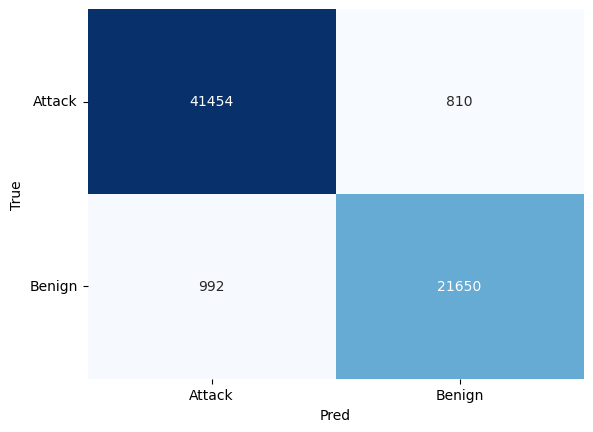

In [14]:
model = base_model_call(x_train, y_train, protected_feature, True)
y_pred = model.predict(x_test)
Model_Metrics_Visualizer(y_test, y_pred)


SHAP Explanations for the BASE Model (f)
Using 1000 samples from x_test for SHAP explanation calculation.


PermutationExplainer explainer: 1001it [01:41,  9.11it/s]                         


SHAP Summary (Base Model - using 1000 test samples)


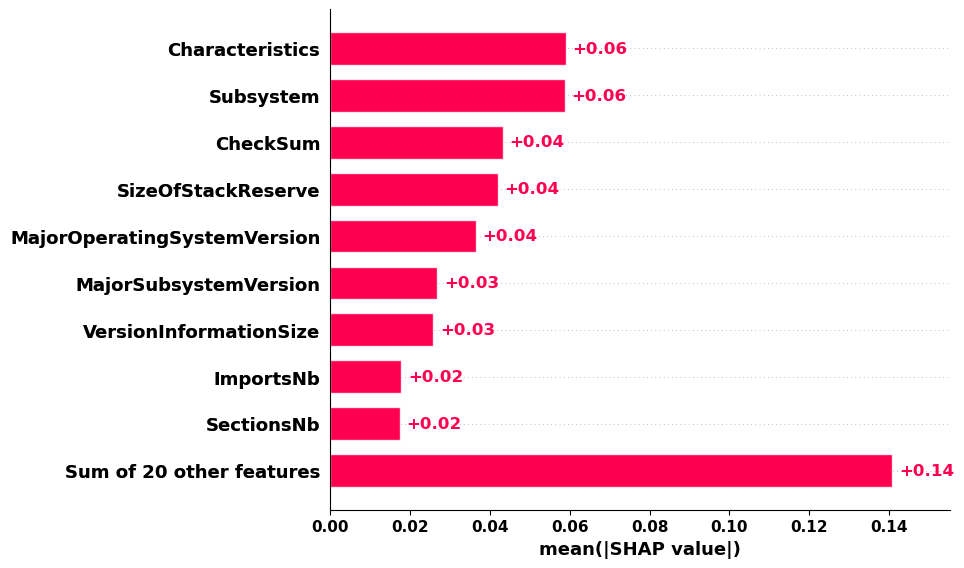

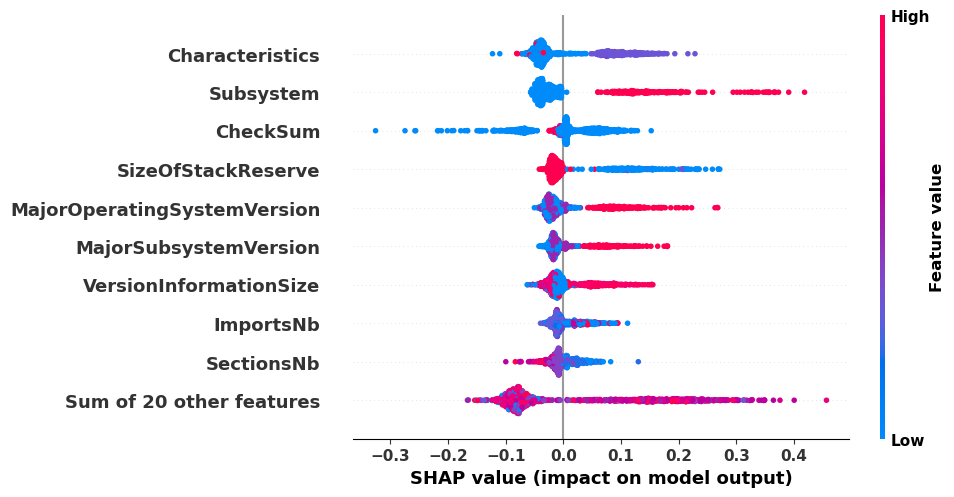

Mean |SHAP| for Subsystem (Base Model): 0.0588


/home/jn/Desktop/Adversarial_Attack_On_XAI/Utils/output_shuffling_attack.py:753: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot.show()


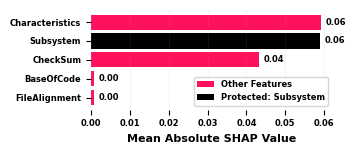

In [15]:
Base_Model_Explanation(x_test, model, protected_feature, feature_names, superior_outcome_value)

Accuracy: 0.971620497334607
Precision: 0.9715800071071564
Recall: 0.971620497334607
F-1: 0.9715877604910399


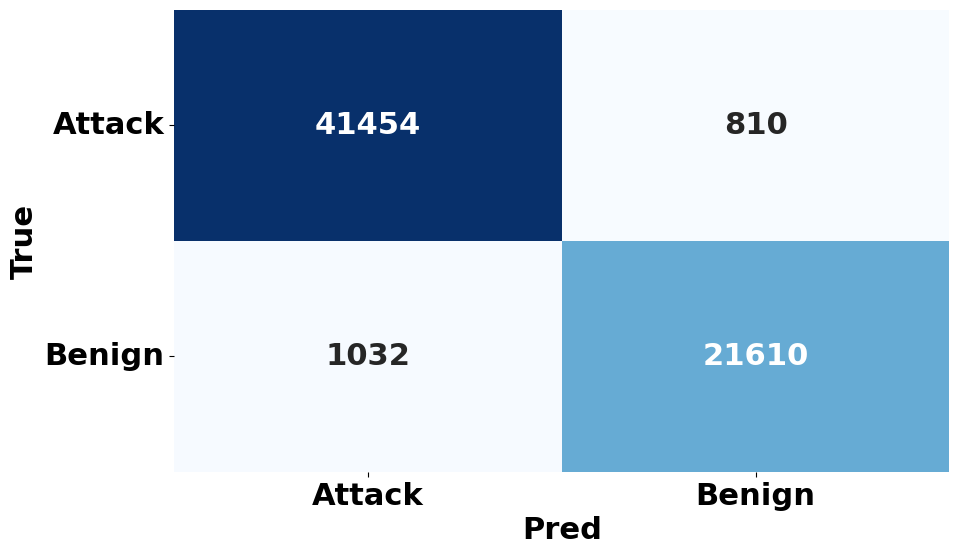

In [16]:
#now we will use the model without the protected feature as paper suggests
model = base_model_call(x_train, y_train, protected_feature, False)
y_pred = model.predict(x_test)
Model_Metrics_Visualizer(y_test, y_pred)

Using 1000 samples from x_test for SHAP explanation calculation.

SHAP Explanations for the ATTACK Model (f') - Dominance Attack


PermutationExplainer explainer: 1001it [01:40,  9.28it/s]                         


SHAP Summary (Attack Model - using 1000 test samples)


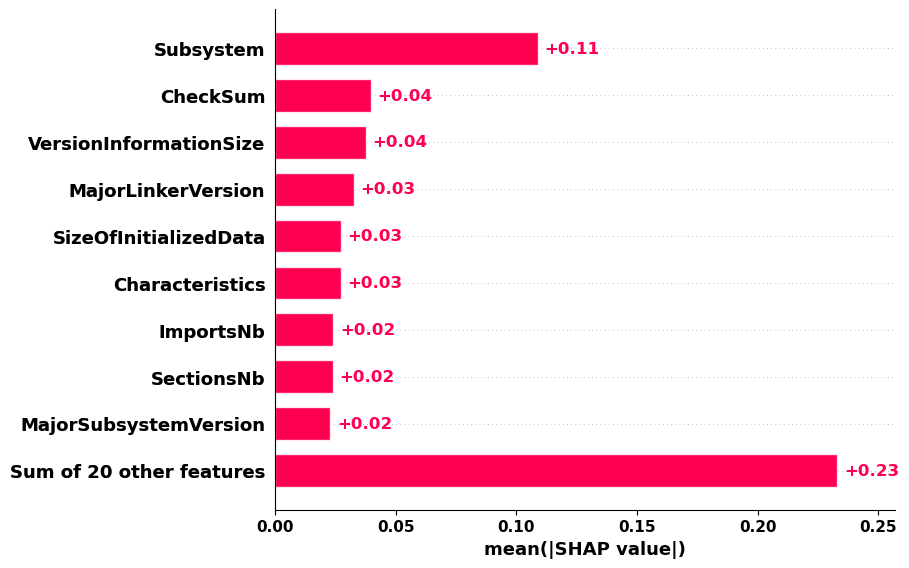

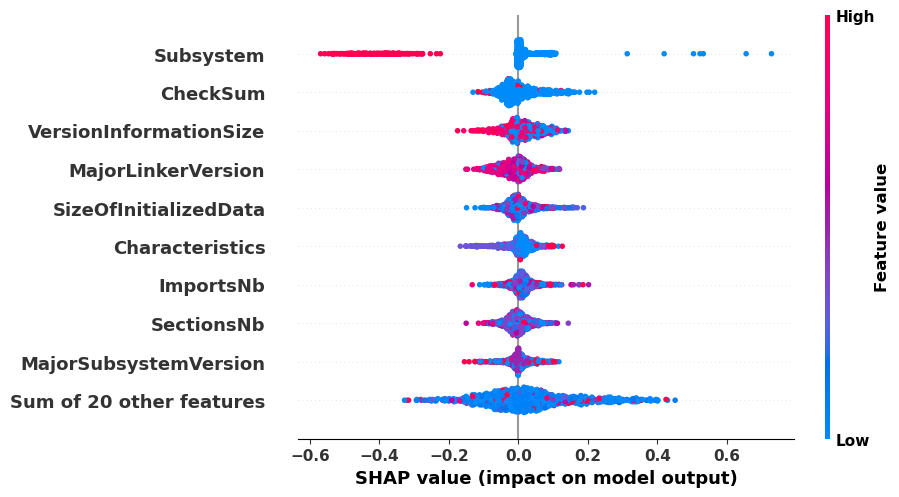

Mean |SHAP| for Subsystem (Attack Model - Dominance): 0.1089


/home/jn/Desktop/Adversarial_Attack_On_XAI/Utils/output_shuffling_attack.py:841: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot.show()


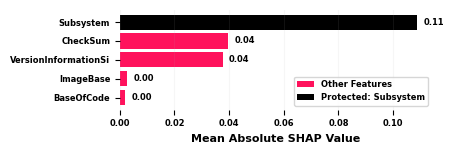

In [17]:
run_attack_analysis(x_test=x_test, base_model=model, feature_names=feature_names,
                        superior_outcome_value=1, protected_feature=protected_feature,
                        attack_type='dominance', attack_params = {protected_feature: 0},
                        shap_sample_size = 1000, random_state = 42)

Using 1000 samples from x_test for SHAP explanation calculation.

SHAP Explanations for the ATTACK Model (f') - Mixing Attack


PermutationExplainer explainer: 1001it [02:28,  6.03it/s]                          


SHAP Summary (Attack Model - using 1000 test samples)


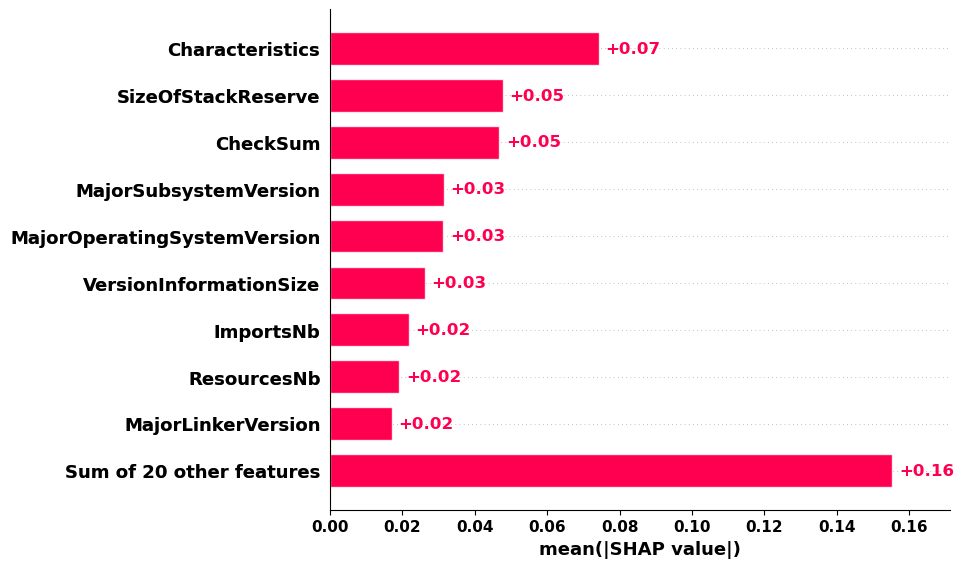

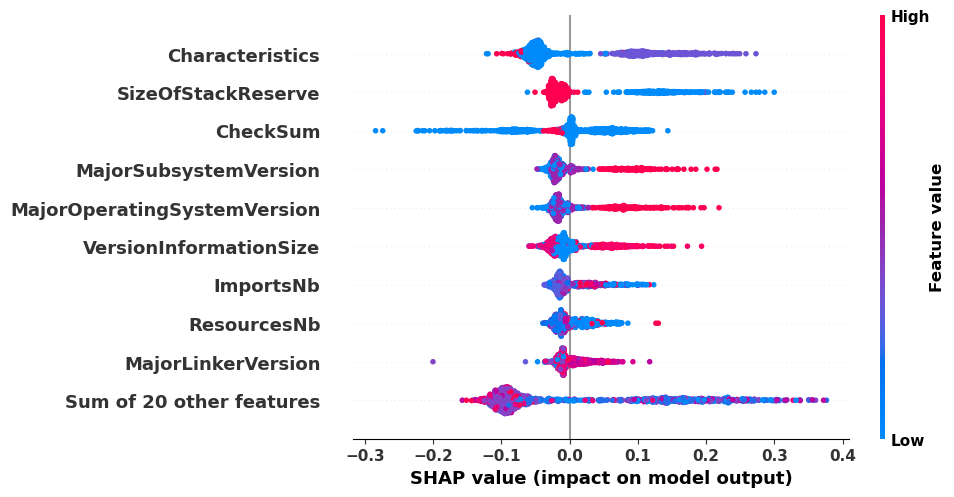

Mean |SHAP| for Subsystem (Attack Model - Mixing): 0.0053


/home/jn/Desktop/Adversarial_Attack_On_XAI/Utils/output_shuffling_attack.py:841: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot.show()


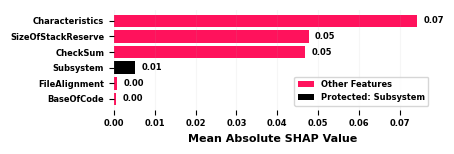

In [18]:
run_attack_analysis(x_test=x_test, base_model=model, feature_names=feature_names,
                        superior_outcome_value=1, protected_feature=protected_feature,
                        attack_type='mixing', attack_params = {protected_feature: 0, 'bias_strength': 0.7},
                        shap_sample_size = 1000, random_state = 42)

Using 1000 samples from x_test for SHAP explanation calculation.

SHAP Explanations for the ATTACK Model (f') - Swapping Attack


PermutationExplainer explainer: 1001it [02:12,  7.06it/s]                          


SHAP Summary (Attack Model - using 1000 test samples)


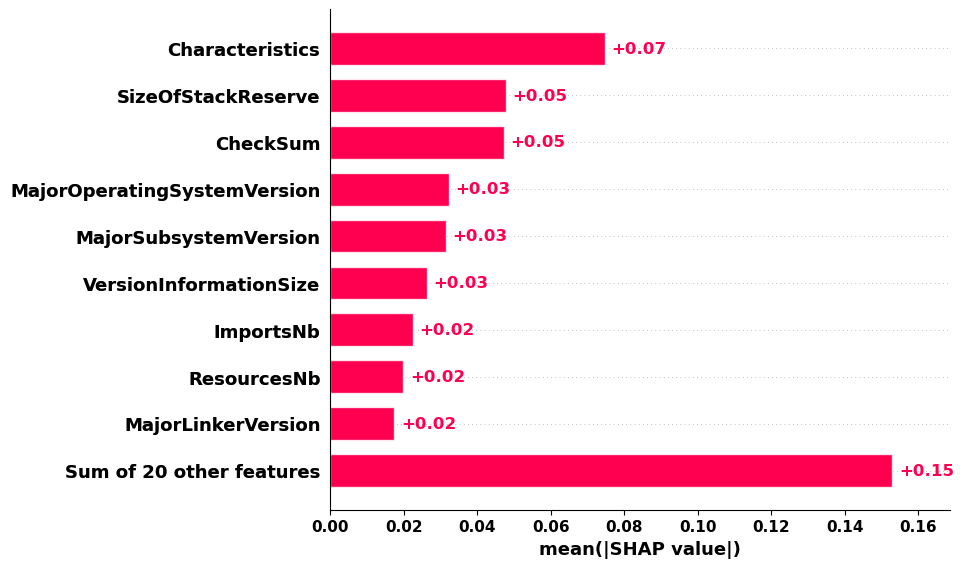

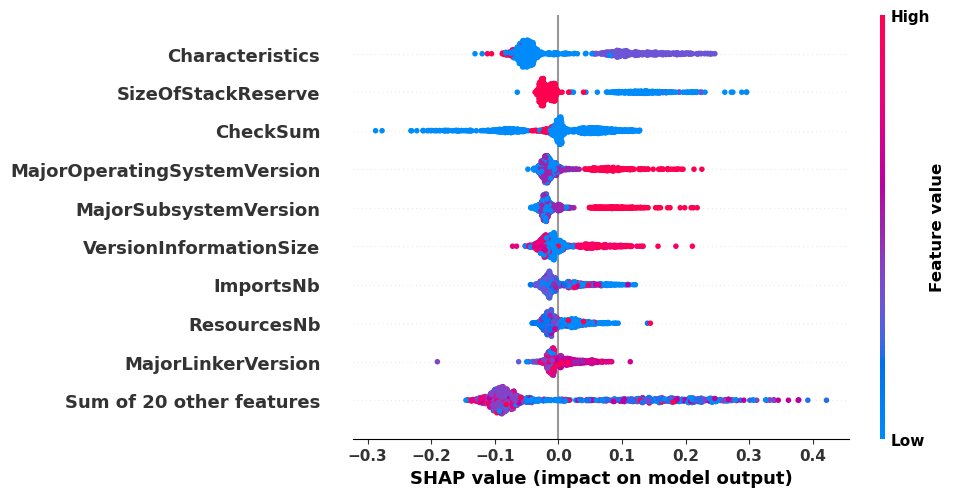

Mean |SHAP| for Subsystem (Attack Model - Swapping): 0.0022


/home/jn/Desktop/Adversarial_Attack_On_XAI/Utils/output_shuffling_attack.py:841: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot.show()


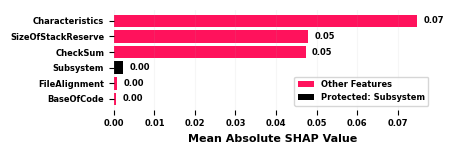

In [19]:
run_attack_analysis(x_test=x_test, base_model=model, feature_names=feature_names,
                        superior_outcome_value=1, protected_feature=protected_feature,
                        attack_type='swapping', attack_params = {protected_feature: 0},
                        shap_sample_size = 1000, random_state = 42)

In [20]:
print("Generating score-based visualization...")
fig_scores = visualize_all_attack_scores_parallel_coords(
        x_test=x_test,
        base_model=model,
        protected_feature=protected_feature,
        superior_outcome_value=1,
        sample_size=500
    )
fig_scores.show()

Generating score-based visualization...


In [21]:
print("\nGenerating ID rank change visualization...")
fig_ranks = visualize_all_attack_ranks_parallel_coords(
        x_test=x_test,
        base_model=model,
        protected_feature=protected_feature,
        superior_outcome_value=1,
        sample_size=500
    )
fig_ranks.show()


Generating ID rank change visualization...
